#### using the synthetic data from Misha. Quick validating of Unet

In [1]:
# ! pip install mrcfile
# ! pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
# check the status of GPU
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']

/trinity/shared/pkg/devel/python/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/trinity/shared/pkg/devel/python/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/trinity/shared/pkg/devel/python/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/trinity/shared/pkg/devel/python/3

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31992263476
locality {
  bus_id: 1
  links {
  }
}
incarnation: 96236838326581407
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0"



[None]

In [2]:
# neptune document

import neptune.new as neptune

run = neptune.init(
    project='leeleeroy/UNet-2D-EM',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
    name = "UNet2D_256_padding",  
)  # necessary credentials, the name could be used to reproduce the results 


# for callbacks in training

from neptune.new.integrations.tensorflow_keras import NeptuneCallback

neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
# neptune document the hyper param.

PARAMS = {'patchify': 128,
          "optimizer": {"learning_rate": 0.001, "beta_1":0.9,"optimizer": "Adam"},
          'epochs':100,
          'batch_size':16}

# log hyper-parameters
run['hyper-parameters'] = PARAMS
run["sys/tags"].add(["model-type: ", "2D_128"])

https://app.neptune.ai/leeleeroy/UNet-2D-EM/e/UN-41


/home/li52/.local/lib/python3.6/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")
/home/li52/.local/lib/python3.6/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [3]:
# check the status of GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']
# gpu_device_name = tf.test.gpu_device_name()
# print(gpu_device_name)

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31992263476
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10080990521991327382
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0"



[None]

In [4]:
# data loading
import os
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'

In [5]:
def readMRC(path):
    with mrcfile.open(path, mode='r+', permissive=True) as mrc:
        mrc.header.map = mrcfile.constants.MAP_ID # for synthetic data, need to generate ID
        data = mrc.data
    return data

In [6]:
DATA_PATH = './synthetic/'  # in hemera, only use relative path
data_ids = next(os.walk(DATA_PATH))[1]

In [7]:
import os
import pandas as pd
raw = []
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):  
    path = DATA_PATH + id_
    datanames = os.listdir(path)
    for dataname in datanames:
        if os.path.splitext(dataname)[1] == '.mrc': # all .mrc under the path
            temp = readMRC(path + "/" + dataname).astype(np.uint8)
            raw.append(temp)
            print(dataname)
            
focal = raw[0:3]
GT = raw[3:len(raw)]
del raw, temp, datanames, dataname, path, data_ids, n, id_

  0%|          | 0/3 [00:00<?, ?it/s]/home/li52/.local/lib/python3.6/site-packages/mrcfile/mrcinterpreter.py:219: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


tomo2_focalseries.mrc
tomo3_focalseries.mrc
tomo1_focalseries.mrc
tomo2_groundtruth.mrc
tomo3_groundtruth.mrc


100%|██████████| 3/3 [00:00<00:00, 12.05it/s]

tomo1_groundtruth.mrc


uint8


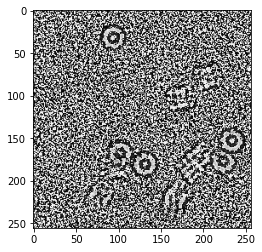

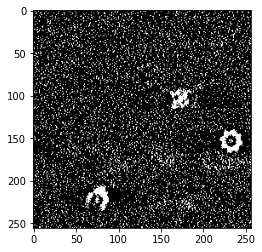

In [8]:
# sanity check for the data
import random
testF = focal[0]
testF.shape

testIm = testF[random.randint(0, testF.shape[0]),...]
print(testF.dtype)
plt.figure('focal');plt.imshow(testIm, cmap='gray')

testGT = GT[0]
testGT.shape

testIm = testGT[random.randint(0,testGT.shape[0]),...]
plt.figure();plt.imshow(testIm, cmap='gray')

In [9]:
# training dataset raw
# select the firt two (focal+ GT) as training, third as testing
import torchio as tio
from patchify import patchify, unpatchify

train_raw = np.vstack(([focal[0], focal[1]]))  # ;
label = np.vstack(([GT[0], GT[1]]))#;label = train_label[...,np.newaxis]
# print(train_raw.shape)


focal stack shape:  (202, 256, 256)
volume shape:  (512, 256, 256)


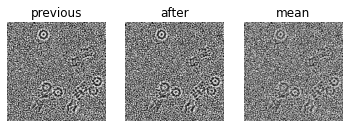

In [10]:
print('focal stack shape: ', train_raw.shape)
print('volume shape: ', label.shape)
meanSlice = (train_raw[0] + train_raw[1])/2
testSet = [train_raw[0], train_raw[1], meanSlice.astype('uint8')]

n_samples = 3
titles = ['previous', 'after', 'mean']
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.axis('off')
    plt.imshow(testSet[i], cmap='gray')
    plt.title(titles[i])
plt.show()

In [11]:
# padding two slices between each twos

def middle_padd(dataset):
    new_stack = []
    for i in range(dataset.shape[0]-1):
        previous = dataset[i]
        after = dataset[i+1]
        mean = (previous + after) / 2
        new_stack.append(previous)
        new_stack.append(mean.astype('uint8'))
    new_stack = np.asarray(new_stack) 
    return new_stack

In [12]:
new_stack = middle_padd(train_raw)
trainData = new_stack[...,np.newaxis].transpose((3,1,2,0))

In [13]:
# padding into the same size
TARGET = label.shape[0]
trainIO = tio.ScalarImage(tensor=trainData)
target_shape = 256,256,TARGET
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(trainIO) # padding with mean
train_padd = resized.numpy().transpose((3,1,2,0)); train_padd = train_padd[...,0]
print(train_padd.shape);print(label.shape)

(512, 256, 256)
(512, 256, 256)


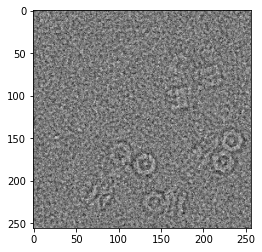

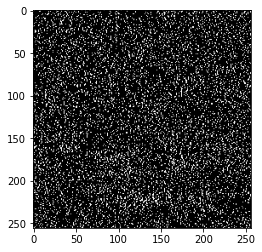

In [14]:
# sanity check for the padding part

temp = train_padd[0]

plt.imshow(temp, cmap='gray')

plt.figure(); plt.imshow(label[0], cmap='gray')

In [15]:
# testing dataset raw
X_test = focal[2]
Y_test_label = GT[2]; Y_test_label = (Y_test_label > 0.5).astype(np.float) 

X_test = middle_padd(X_test)
X_test = X_test[...,np.newaxis].transpose((3,1,2,0))

In [16]:
# patch into the same size through tio

testIO = tio.ScalarImage(tensor=X_test)
target_shape = 256,256,256
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(testIO)
test_padd = resized.numpy().transpose((3,1,2,0)); test_padd = test_padd[...,0];
print(test_padd.shape);print(Y_test_label.shape)

(256, 256, 256)
(256, 256, 256)


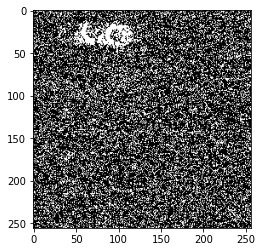

In [17]:
# sanity check
test = Y_test_label[100,...]
plt.imshow(test,cmap='gray')

In [18]:
# patchify the images
def rawPatch(imageStack,patchPara):
    all_img_patches = []

    for img in range(imageStack.shape[0]):
        large_image = imageStack[img]

        patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])  # no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1

                all_img_patches.append(single_patch_img)
    
    return all_img_patches, patches_img.shape
    

In [19]:
# train dataset
patchPara = {'x': 128, 'y': 128, 'step':128}
Xtrain_patches, _ = rawPatch(train_padd, patchPara);Xtrain_patches = np.stack((Xtrain_patches,)*3, axis=-1) # dock 3 times, the model expects 3 channel
# print(Xtrain_patches.shape)

Ytrain_patches, _ = rawPatch(label, patchPara);Ytrain_patches = np.expand_dims(Ytrain_patches, -1)
Ytrain_patches = (Ytrain_patches > 0.5).astype(np.float) # binarize the data

# test dataset
Xtest_patches, patchSize = rawPatch(test_padd, patchPara);Xtest_patches = np.stack((Xtest_patches,)*3, axis=-1)
Ytest_patches, _ = rawPatch(Y_test_label, patchPara);Ytest_patches = np.expand_dims(Ytest_patches, -1)
Ytest_patches = (Ytest_patches > 0.5).astype(np.float)
print(Xtest_patches.shape);print(Ytest_patches.shape)

(1024, 128, 128, 3)
(1024, 128, 128, 1)


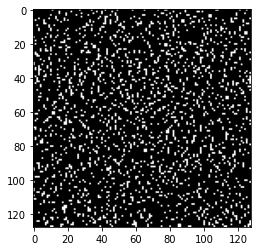

In [20]:
plt.imshow(Ytrain_patches[700],cmap='gray')

In [21]:
# define the parameters of images
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [22]:
import tensorflow.keras as k

In [23]:
# generating the model on our own

inputs = k.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

s = k.layers.Lambda(lambda x: x)(inputs)  # transfer the data into float ! sometimes here should be divded with 255
c1 = k.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)  # kernel_init initilaize the parameters
c1 = k.layers.Dropout(0.1)(c1)
c1 = k.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = k.layers.MaxPooling2D((2,2))(c1)

# c1 - c5 are contraction paths
c2 = k.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = k.layers.Dropout(0.1)(c2)
c2 = k.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = k.layers.MaxPooling2D((2, 2))(c2)
 
c3 = k.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = k.layers.Dropout(0.2)(c3)
c3 = k.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = k.layers.MaxPooling2D((2, 2))(c3)
 
c4 = k.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = k.layers.Dropout(0.2)(c4)
c4 = k.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = k.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = k.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = k.layers.Dropout(0.3)(c5)
c5 = k.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = k.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = k.layers.concatenate([u6, c4])
c6 = k.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = k.layers.Dropout(0.2)(c6)
c6 = k.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = k.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = k.layers.concatenate([u7, c3])
c7 = k.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = k.layers.Dropout(0.2)(c7)
c7 = k.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = k.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = k.layers.concatenate([u8, c2])
c8 = k.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = k.layers.Dropout(0.1)(c8)
c8 = k.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = k.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = k.layers.concatenate([u9, c1], axis=3)
c9 = k.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = k.layers.Dropout(0.1)(c9)
c9 = k.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = k.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

In [26]:
# construct the model
model = k.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [27]:
# setting checkpoints
checkpointer = k.callbacks.ModelCheckpoint('./checkPoint/synthetic_padd.h5', verbose=1, save_best_only=True)
callbacks = [
    #k.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    neptune_cbk, 
    k.callbacks.TensorBoard(log_dir = 'logsHPadding')  # save in new folder in hemera. Also update in neptune
]

# start to train
X_train = Xtrain_patches; Y_train = Ytrain_patches
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100,callbacks=callbacks) # assign the param into models

Train on 1843 samples, validate on 205 samples
Epoch 1/100
1843/1843 [==============================] - 5s 3ms/step - loss: 7.3667 - acc: 0.8315 - val_loss: 6.4583 - val_acc: 0.8600
Epoch 2/100
1843/1843 [==============================] - 2s 1ms/step - loss: 6.6149 - acc: 0.8580 - val_loss: 6.4361 - val_acc: 0.8600
Epoch 3/100
1843/1843 [==============================] - 2s 1ms/step - loss: 6.5466 - acc: 0.8580 - val_loss: 6.4583 - val_acc: 0.8600
Epoch 4/100
1843/1843 [==============================] - 2s 1ms/step - loss: 6.5364 - acc: 0.8580 - val_loss: 6.4433 - val_acc: 0.8600
Epoch 5/100
1843/1843 [==============================] - 2s 1ms/step - loss: 6.5291 - acc: 0.8580 - val_loss: 6.4305 - val_acc: 0.8600
Epoch 6/100
1843/1843 [==============================] - 2s 1ms/step - loss: 6.5220 - acc: 0.8580 - val_loss: 6.4416 - val_acc: 0.8600
Epoch 7/100
1843/1843 [==============================] - 2s 1ms/step - loss: 6.5168 - acc: 0.8580 - val_loss: 6.4195 - val_acc: 0.8600
Epoch 8/

In [28]:
# prdiction
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

X_test = Xtest_patches; Y_test = Ytest_patches
preds_test = model.predict(X_test, verbose=1) 
print(preds_test.shape)

1024/1024 [==============================] - 0s 398us/step
(1024, 128, 128, 1)


In [29]:
# unpathcify the prediction
Num = np.array(preds_test.shape[0]/4).astype(np.int)
large_image = train_padd[0]
recons = np.split(np.squeeze(preds_test), Num, axis=0)  # reconstruction
all_recon_img = []

for i in range(Num):
    temp = recons[i]
    temp = np.reshape(temp, patchSize)
    tempPic = unpatchify(temp, large_image.shape)
    all_recon_img.append(tempPic)

all_recon_img = np.stack(np.array(all_recon_img), axis=0)

(256, 256, 256)
current slice: 155


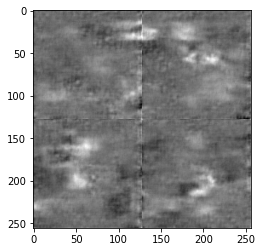

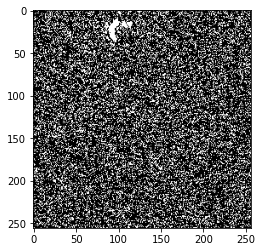

In [30]:
print(all_recon_img.shape)
Num = random.randint(0,all_recon_img.shape[0])
plt.imshow(all_recon_img[Num], cmap='gray')
print('current slice:', Num)

plt.figure();plt.imshow(Y_test_label[Num], cmap='gray')

In [31]:
# np.save("all_reconH.npy",all_recon_img)  # hemera version

#save model as local

np.save("./tempData/paddPred.npy", all_recon_img)
np.save("./tempData/paddGT.npy", Y_test_label)

In [33]:
for i in range(all_recon_img.shape[0]):
    predTemp = all_recon_img[i]
    predTemp = np.interp(predTemp, (predTemp.min(), predTemp.max()), (0, 1))  # neptune only receives 0-1
    GTTemp = Y_test_label[i]
    GTTemp = np.interp(GTTemp, (GTTemp.min(), GTTemp.max()), (0, 1))
    bar = np.zeros((predTemp.shape[0], 15))
    combTemp = np.concatenate((np.squeeze(predTemp),bar,np.squeeze(GTTemp)), axis=1)
    run["test/gen_vs_GT"].log(neptune.types.File.as_image(combTemp), name=str(i), descripttion='generated vs, GT')  # upload the test results

In [ ]:
run.stop()  # stop logging

In [ ]:
# # write out mrc file

# test = np.load("all_reconH.npy")
# print(test.shape)

# plt.imshow(test[154], cmap='gray')


# mrc = mrcfile.new('all_recon.mrc', overwrite=True)
# mrc.set_data(test)
# mrc.close